# DGANs my implementations

In [1]:
import tensorflow as tf
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import os
from glob import glob

import helper

%matplotlib inline

## Step 1: The Data

### Get the data

In [2]:
data_dir = './data'
helper.download_extract('celeba', data_dir)

Found celeba Data


### Explore the data

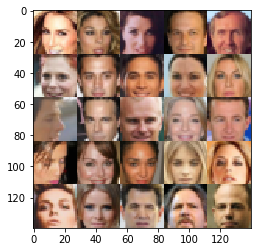

In [3]:
show_n_images = 25
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
plt.imshow(helper.images_square_grid(mnist_images, 'RGB'))

### Preprocess the data

<ul>
    <li> Cropped to remove parts of the image that don't include a face </li>
    <li> Resized down to 28x28 </li>
</ul>

## Step 2: Build the Neural Network

You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the version of Tensorflow and access to GPU

In [4]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.5.0


C:\Users\simon\Anaconda3\envs\gameplai\lib\site-packages\ipykernel\__main__.py:11: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Create TF placeholders for the Neural Network
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in a tuple

In [5]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # COMPLETED: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    
    return inputs_real, inputs_z, learning_rate
"""


def model_inputs(real_dim, z_dim):
    # Discriminator inputs
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name="input_real")
    
    # Generator inputs
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")

    return inputs_real, inputs_z
"""

'\n\n\ndef model_inputs(real_dim, z_dim):\n    # Discriminator inputs\n    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name="input_real")\n    \n    # Generator inputs\n    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")\n\n    return inputs_real, inputs_z\n'

### Generator Network
#### Variable Scope
Use tf.variable_scope <b> for 2 reasons </b>:
<ul>
    <li> Make sure all varaibles names start with generator / discriminator (will help out later when training the separate networks </li>
    <li> Also want <b> to reuse these networks with different inputs </b></li>
        <ul>
            <li> For the generator: we're going to train it but also <b>sample from it as we're training after training </b> </li>
            <li> For the discriminator: need to share variables between the fake and real input images </li>
    </ul>
</ul>
<p> So we can use the reuse keyword to <b> tell TensorFlow to reuse the var instead of createing new one if we build the graph again</b></p>

#### Leaky ReLU
Avoid gradient vanishing

#### Tanh Output
Generator has been found to perform the best <b> with tanh for the generator output </b>
<br>
![DCGAN Generator](dcgan-svhn/assets/dcgan.png)

- Leaky ReLU in all layers except for the last tanh layer
- Normalization on all the transposed convnets except the last one

<br> <br>
<b>Transposed convnets --> normalization --> leaky ReLU</b>

In [6]:
def generator(z, output_channel_dim, is_train=True):
    ''' Build the generator network.
    
        Arguments
        ---------
        z : Input tensor for the generator
        output_channel_dim : Shape of the generator output
        n_units : Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out: 
    '''
    with tf.variable_scope("generator", reuse= not is_train):
        
        # First FC layer
        fc1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it
        fc1 = tf.reshape(fc1, (-1, 7, 7, 512))
        
        # Batch norm
        fc1 = tf.layers.batch_normalization (inputs = fc1, training=is_train)
        
        # Leaky ReLU
        fc1 = tf.nn.leaky_relu(fc1, alpha=alpha)
        ## 4x4x512
        
        
        # Transposed conv 1
        trans_conv1 = tf.layers.conv2d_transpose(inputs = fc1,
                                  filters = 256,
                                  kernel_size = 5,
                                  strides = 1,
                                  padding = "same")
        
        # Batch Norm
        trans_conv1 = tf.layers.batch_normalization (inputs = trans_conv1, training=is_train)
        
        # Leaky ReLU
        trans_conv1 = tf.nn.leaky_relu(trans_conv1, alpha=alpha)
        ## 8x8x256
        
        
        # Transposed conv 2
        trans_conv2 = tf.layers.conv2d_transpose(inputs = trans_conv1,
                                  filters = 128,
                                  kernel_size = 5,
                                  strides = 2,
                                  padding = "same")
        
        # Batch Norm
        trans_conv2 = tf.layers.batch_normalization(inputs = trans_conv2, training=is_train)
        
        # Leaky ReLU
        trans_conv2 = tf.nn.leaky_relu(trans_conv2, alpha=alpha)
        ## 16x16x128
        
        # Transposed conv 3
        trans_conv3 = tf.layers.conv2d_transpose(inputs = trans_conv2,
                                  filters = 64,
                                  kernel_size = 5,
                                  strides = 2,
                                  padding = "same")
        
        # Batch Norm
        trans_conv3 = tf.layers.batch_normalization(inputs = trans_conv3, training=is_train)
        
        # Leaky ReLU
        trans_conv3 = tf.nn.leaky_relu(trans_conv3, alpha=alpha)
        ## 64
        
        
        
        
        # Output
        logits = tf.layers.conv2d_transpose(inputs = trans_conv2,
                                  filters = output_channel_dim,
                                  kernel_size = 5,
                                  strides = 2,
                                  padding = "same")
        
        out = tf.tanh(logits)
        
        return out
        

### Discriminator
- Input is 32x32x3 tensors/images
- Depths starting with 32 and then *2 depth as you add layers
- No downsampling using only <b> strided conv layers with no maxpool layers </b>
- No batchnorm in input layer

<b> convolution > batch norm > leaky ReLU </b>

In [7]:
def discriminator(x, reuse=False, alpha = 0.2):
    ''' Build the discriminator network.
    
        Arguments
        ---------
        x : Input tensor for the discriminator
        n_units: Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out, logits: 
    '''
    with tf.variable_scope("discriminator", reuse=reuse): 
        # Input layer 28x28x3
        conv1 = tf.layers.conv2d(inputs = x,
                                filters = 64,
                                kernel_size = 5,
                                strides = 2,
                                padding = "same")
        
        
        # Leaky ReLU
        conv1 = tf.nn.leaky_relu(conv1, alpha=alpha)
        ## 16x16x64
        
        
        # conv layer 16x16x64
        conv2 = tf.layers.conv2d(inputs = conv1,
                                filters = 128,
                                kernel_size = 5,
                                strides = 1,
                                padding = "same")
        
        # Batchnorm
        conv2 = tf.layers.batch_normalization (conv2, training=True)
        
        # Leaky ReLU
        conv2 = tf.nn.leaky_relu(conv2, alpha=alpha)
        ## 8x8x128
        
        
        # conv layer 8x8x128
        conv3 = tf.layers.conv2d(inputs = conv2,
                                filters = 256,
                                kernel_size = 5,
                                strides = 2,
                                padding = "same")
        
        # Batchnorm
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        
        # Leaky ReLU
        conv3 = tf.nn.leaky_relu(conv3, alpha=alpha)
        ## 4x4x256
        
        
        # Flatten it
        flatten = tf.reshape(conv3, (-1, 7*7*256))
        
        # Logits
        logits = tf.layers.dense(inputs = flatten,
                                units = 1,
                                activation = None)
        
        
        out = tf.nn.softmax(logits)
        
        return out, logits

### Discriminator and generator losses

We train the g and d <b> at the same time </b> so we need losses for <b> both networks </b>

#### Discriminator Loss
Sum of loss for real and fake images
<br>
d_loss = d_loss_real + d_loss_fake
<br><br>
The losses will by <b> sigmoid cross entropy + wrap with tf.reduce_mean to get the mean for all the images in the batch.
</b>

##### Real image loss
<ul>
    <li>Use `d_logits_real` and labels <b> are all 1 (since all real data is real) </b></li>
    <li>Label smoothing:  To help the discriminator generalize better, the labels are <b>reduced a bit from 1.0 to 0.9</b></li>

`labels = tf.ones_like(tensor) * (1 - smooth)`
For the real image loss, use the real logits and (smoothed) labels of ones. 
##### Fake image loss
<li>Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that</li>
For the fake image loss, use the fake logits with labels of all zeros

#### Generator Loss
The generator loss again uses the fake logits from the discriminator, but this time the labels are all ones because the generator wants to fool the discriminator.

In [8]:
def model_loss(input_real, input_z, output_channel_dim, alpha):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # Generator network here
    g_model = generator(input_z, output_channel_dim, is_train=True)   
    # g_model is the generator output
    
    # Discriminator network here
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    # Calculate losses
    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss

### Optimizers
<ul>
    <li>Update the generator and discriminator <b>separately</b></li>
    <li> So we need to get the var for each part : we use `tf.trainable_variables()`. This creates a list of all the variables we've defined in our graph. </li>
</ul>
- the train operations are wrapped in a with tf.control_dependencies block so the batch normalization layers can update their population statistics.

In [9]:
def model_optimizers(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # Generator update
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    # Optimizers
    with tf.control_dependencies(gen_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt

## Step 3: Neural Network Training

### Show output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    plt.imshow(images_grid, cmap=cmap)
    plt.show()

### Building the model

## Training

In [11]:
"""
def train(model, dataset, epochs, batch_size, get_batches, data_image_mode, data_shape,  print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    
    # Sample random noise for G
    sample_z = np.random.uniform(-1, 1, size=(50, z_size))

    samples = []
    losses = []
    steps = 0



                
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for batch_images in get_batches(batch_size):
                steps +=1
                
                # Thanks for the advice thyago
                batch_images = batch_images * 2 

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))


                # Run optimizers
                _ = sess.run(model.d_opt, feed_dict={model.input_real: batch_images, model.input_z: batch_z})
                _ = sess.run(model.g_opt, feed_dict={model.input_z: batch_z})


                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = model.d_loss.eval({model.input_z: batch_z, model.input_real: batch_images})
                    train_loss_g = model.g_loss.eval({model.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))    
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                    show_generator_output(sess, 25, model.input_z, data_shape[3], data_image_mode)

                if steps % show_every == 0:
                        gen_samples = sess.run(
                                       generator(model.input_z, 3, reuse=True, training=False),
                                       feed_dict={model.input_z: sample_z})
                        samples.append(gen_samples)
                        _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                        plt.show()

            saver.save(sess, './checkpoints/generator.ckpt')

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)   
    
    return losses, samples
"""

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # COMPLETED: Build Model
    
    
    #tf.reset_default_graph()
        
    # Create our input placeholders
    input_images, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        

    # Losses
    d_loss, g_loss = model_loss(input_images, input_z,
                                              data_shape[3], alpha)
        
    # Optimizers
    d_opt, g_opt = model_optimizers(d_loss, g_loss, learning_rate, beta1)
    
    i = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # Thanks for the advice thyago
                batch_images = batch_images * 2 
                
                # COMPLETED: Train Model
                i += 1

                # Random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr: learning_rate})

                if i % 10 == 0:
                
                    train_loss_d = d_loss.eval({input_z: batch_z, input_images: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
    return losses, samples

## Hyperparameters

Gans are <b> very sensitive to hyperparemeters </b>

In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [12]:
# Size input image for discriminator
real_size = (28,28,3)

# Size of latent vector to generator
z_dim = 100
learning_rate = 0.0002
batch_size = 64
epochs = 25
alpha = 0.2
beta1 = 0.5

# Create the network
#model = DGAN(real_size, z_size, learning_rate, alpha, beta1)

In [13]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

Epoch 1/25... Discriminator Loss: 2.2926... Generator Loss: 0.1925


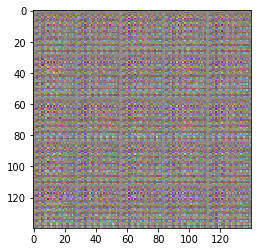

Epoch 1/25... Discriminator Loss: 1.1337... Generator Loss: 0.6833


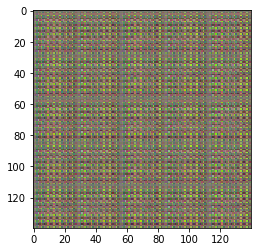

Epoch 1/25... Discriminator Loss: 1.3435... Generator Loss: 0.5156


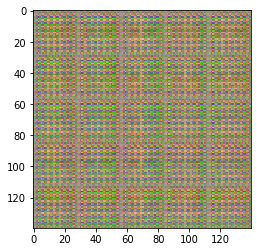

Epoch 1/25... Discriminator Loss: 1.1381... Generator Loss: 6.1680


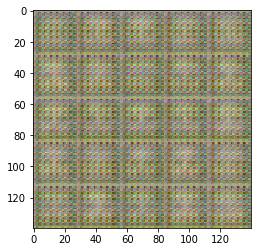

Epoch 1/25... Discriminator Loss: 0.5985... Generator Loss: 2.1820


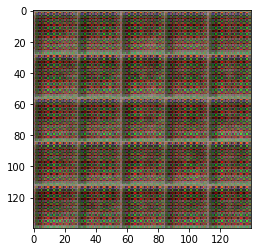

Epoch 1/25... Discriminator Loss: 1.1766... Generator Loss: 1.1105


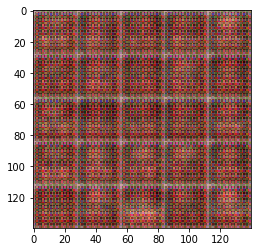

KeyboardInterrupt: 

In [14]:
# Load the data and train the network here
dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))

with tf.Graph().as_default():
    losses, samples = train(epochs, batch_size, z_dim, learning_rate, beta1, dataset.get_batches,
          dataset.shape, dataset.image_mode, alpha)


## Training Loss

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))